In [17]:
# those modules are almost always imported when working with model data
%matplotlib inline
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import xarray as xr # the major tool to work with NetCDF data!

import netCDF4
import os
from glob import glob
import numpy as np
import scipy.interpolate
import matplotlib.pyplot as plt
import pickle as pickle

## First load Gravity CSV for sampling

In [18]:
import pandas as pd
from glob import glob
def importOIBgrav(basedir, timedir):
    # datadir = 'IGGRV1B/temp'
    # infile = 'IGGRV1B_20091104_13100500_V016'
    # infile = 'IGGRV1B_20091031_11020500_V016'
    # infile = 'IGGRV1B_20091116_15124500_V016'
    suffix = '.txt'
    pattern = os.path.join(basedir, timedir, 'IGGRV1B_20161114_11243000_V017*' + suffix)
    infile = sorted(glob(pattern))  # , key=alphanum_key)

    ### Read ascii file as csv
    # metadata ends on line 69, column names on line 70
    headers = (
        'LAT', 'LONG', 'DATE', 'DOY', 'TIME', 'FLT', 'PSX', 'PSY', 'WGSHGT', 'FX', 'FY', 'FZ', 'EOTGRAV', 'FACOR',
        'INTCOR',
        'FAG070', 'FAG100', 'FAG140', 'FLTENVIRO')
    # print "Reading gravity file: %s" % infile[0] + suffix %TODO why did I think this would be a list?
    print("Reading gravity file: %s" % infile[0] + suffix)
    df = pd.read_csv(infile[0], delimiter=r"\s+", header=None, names=headers, skiprows=70)
    # headers = df.columns[1:df.shape[1]]
    # df.rename(columns=dict(zip(df.columns,headers)), inplace=True)
    # df.rename(columns={'LONG': 'LON'}, inplace=True)
    # df['ENVIRO'] = df.columns[[19]]
    # df.drop(df.columns['FLTENVIRO'],axis=1,inplace=True)

    ### do some DATETIME operations
    df['DATETIME'] = (df.DATE * 1e5) + df.TIME
    df['DATE'] = pd.to_datetime(df['DATE'], format='%Y%m%d')
    df['UNIX'] = df['DATE'].astype(np.int64) // 10 ** 9
    df['UNIX'] = df['UNIX'] + df['TIME']
    df['iunix'] = pd.to_datetime(df['UNIX'] * 10 ** 3, unit='ms')
    df.drop(['DATETIME'], axis=1, inplace=True)
    df = df.set_index('iunix')
    return df

basedir = '/Users/dporter/Documents/data_local/Antarctica/OIB/'
datadir = 'IGGRV1B'
timedir = 2016
grav = importOIBgrav(os.path.join(basedir, datadir), str(timedir))


Reading gravity file: /Users/dporter/Documents/data_local/Antarctica/OIB/IGGRV1B/2016/IGGRV1B_20161114_11243000_V017.txt.txt


In [19]:
grav.head()

,LAT,LONG,DATE,DOY,TIME,FLT,PSX,PSY,WGSHGT,FX,FY,FZ,EOTGRAV,FACOR,INTCOR,FAG070,FAG100,FAG140,FLTENVIRO,UNIX
iunix,,,,,,,,,,,,,,,,,,,,
2016-11-14 11:24:30.000,-53.004590,-70.845986,2016-11-14,319,41070.0,621,-3929452.26,1364844.81,50.57,5.01,-15.79,981296.93,NaN,NaN,NaN,NaN,NaN,NaN,-1,1.479123e+09
2016-11-14 11:24:30.500,-53.004590,-70.845986,2016-11-14,319,41070.5,621,-3929452.26,1364844.81,50.57,4.52,-15.33,981297.13,NaN,NaN,NaN,NaN,NaN,NaN,-1,1.479123e+09
2016-11-14 11:24:31.000,-53.004590,-70.845985,2016-11-14,319,41071.0,621,-3929452.27,1364844.82,50.56,3.46,-14.49,981297.14,NaN,NaN,NaN,NaN,NaN,NaN,-1,1.479123e+09
2016-11-14 11:24:31.500,-53.004590,-70.845985,2016-11-14,319,41071.5,621,-3929452.27,1364844.83,50.55,2.05,-13.60,981296.95,NaN,NaN,NaN,NaN,NaN,NaN,-1,1.479123e+09
2016-11-14 11:24:32.000,-53.004589,-70.845985,2016-11-14,319,41072.0,621,-3929452.28,1364844.85,50.54,0.73,-13.01,981296.61,NaN,NaN,NaN,NaN,NaN,NaN,-1,1.479123e+09


## IBCSO

In [20]:
from osgeo import gdal

basedir = '/Users/dporter/Documents/'
datadir = 'Research/Projects/Quantarctica3/TerrainModels/IBCSO'
suffix = '.tif'
pattern = os.path.join(basedir, datadir, 'ibcso_v1_sid_*' + suffix)
filenames = sorted(glob(pattern))  # , key=alphanum_key)
print(filenames)
gtif = gdal.Open(filenames[0])

['/Users/dporter/Documents/Research/Projects/Quantarctica3/TerrainModels/IBCSO/ibcso_v1_sid_reclass.tif']


In [21]:
# basedir = '/Users/dporter/Documents/'
# datadir = 'Research/Projects/Quantarctica3/TerrainModels/IBCSO'
# suffix = '.tif'
# pattern = os.path.join(basedir, datadir, 'ibcso_v1_sid_*' + suffix)
# filenames = sorted(glob(pattern))  # , key=alphanum_key)
# print(filenames)
# ds = xr.open_dataset(filenames[0])

In [22]:
rb = gtif.GetRasterBand(1)

In [23]:
img_array = rb.ReadAsArray()

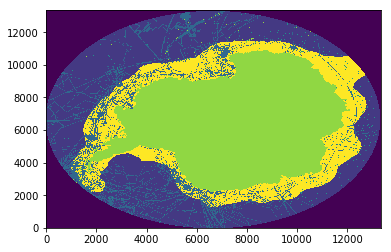

In [26]:
plt.pcolormesh(img_array)